## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Create a deep learning model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report


**QUESTION:** Load dataset and display some lines of the csv file.

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset from Google Drive
dataset_path = "/content/drive/MyDrive/Colab Notebooks/data/ai4i2020.csv"
df = pd.read_csv(dataset_path)

# Display first few rows
print("Dataset Head:")
print(df.head())

# Display dataset shape
print("\nDataset Shape:", df.shape)

Mounted at /content/drive
Dataset Head:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0



```
# Ce texte est au format code
```

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

<ipython-input-11-b6f2c28109fd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Machine failure'], palette='viridis')


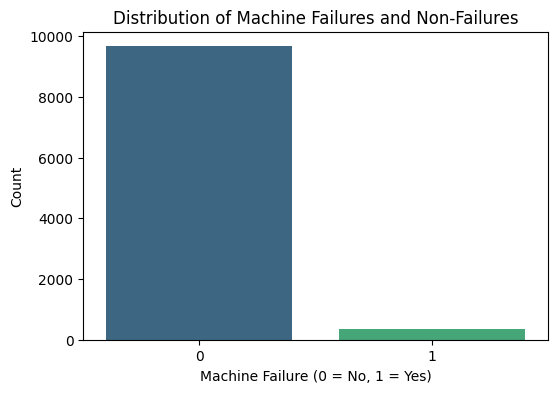

In [ ]:
# Plot distribution of machine failures
plt.figure(figsize=(6,4))
sns.countplot(x=df['Machine failure'], palette='viridis')
plt.xlabel("Machine Failure (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.title("Distribution of Machine Failures and Non-Failures")
plt.show()

**ANALYSIS QUESTION:** What do you observe?

The dataset is highly imbalanced, with far more non-failure cases than failure cases. This imbalance may cause a predictive model to favor non-failures, making failure detection challenging. Techniques like oversampling, undersampling, or class weighting may be needed to improve model performance.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?



The class imbalance will cause the model to bias toward non-failures, leading to:

- Poor failure detection – The model may predict non-failure (0) most of the time, ignoring rare failure cases.
- High accuracy but low recall for failures – The overall accuracy might be high, but the model will struggle to correctly identify failures.
- Need for balancing techniques – Oversampling, undersampling, or class weighting will be necessary to improve failure prediction.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

<ipython-input-12-475b2020a4e9>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette='muted')


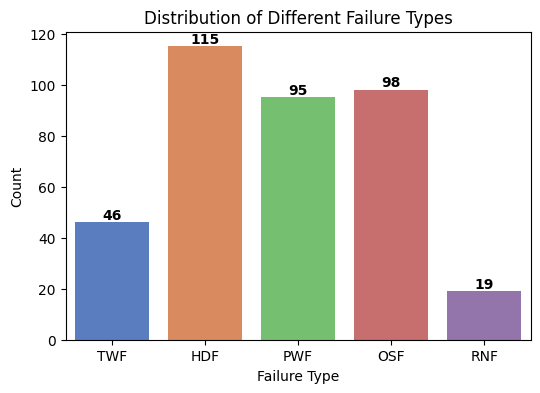

In [ ]:
# Plot distribution of different failure types
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
failure_counts = df[failure_types].sum()

plt.figure(figsize=(6,4))
bars = sns.barplot(x=failure_counts.index, y=failure_counts.values, palette='muted')
plt.xlabel("Failure Type")
plt.ylabel("Count")
plt.title("Distribution of Different Failure Types")

# Display exact values above bars
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), int(bar.get_height()),
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()

**ANALYSIS QUESTION:** What do you observe?

From the bar chart, we observe:

- Imbalanced Failure Types

- Some failure types (HDF, OSF, and PWF) occur more frequently than others (TWF and RNF).
Random Failures (RNF) are the rarest, making them harder to predict accurately.
Impact on Model Learning

- The model may struggle to learn patterns for rare failure types, potentially misclassifying them.
Data balancing techniques (e.g., oversampling or weighted loss functions) may be required to improve prediction performance.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

<ipython-input-13-2443b27a7ad9>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=failure_counts_failed.index, y=failure_counts_failed.values, palette='pastel')


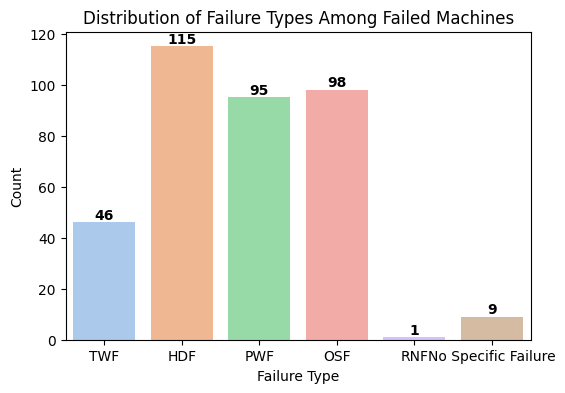

In [ ]:
# Plot distribution of failure types among machines that failed
failed_machines = df[df['Machine failure'] == 1]
failure_counts_failed = failed_machines[failure_types].sum()

# Count cases where a machine failed but no specific failure type was recorded
no_specific_failure = failed_machines[(failed_machines[failure_types].sum(axis=1) == 0)].shape[0]

# Append 'No Specific Failure' category using pandas concat (since append is deprecated)
failure_counts_failed = pd.concat([failure_counts_failed, pd.Series({'No Specific Failure': no_specific_failure})])

plt.figure(figsize=(6,4))
bars = sns.barplot(x=failure_counts_failed.index, y=failure_counts_failed.values, palette='pastel')
plt.xlabel("Failure Type")
plt.ylabel("Count")
plt.title("Distribution of Failure Types Among Failed Machines")

# Display exact values above bars
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), int(bar.get_height()),
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.show()


**ANALYSIS QUESTION:** What do you observe compared to the previous question ? What can you conclude?



- Key difference: The first analysis included all machines, while this one focuses only on failed machines.
- Observations: HDF, OSF, and PWF are the most frequent failures. RNF is extremely rare (only 1 case).
New insight: 9 failed machines have no recorded failure type, suggesting missing labels or unidentified failures.
- Conclusion: The model may struggle with rare failure types and "No Specific Failure" cases, requiring data balancing or label refinement.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [ ]:
# Display column names and data types
print("\nDataset Columns and Data Types:")
print(df.dtypes)


Dataset Columns and Data Types:
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

### **Inputs and Outputs for Model Training**  

#### **Inputs (Features)**
We will use the machine’s **operating conditions and sensor data** as input features:  
- **Air temperature [K]**  
- **Process temperature [K]**  
- **Rotational speed [rpm]**  
- **Torque [Nm]**  
- **Tool wear [min]**  
- **Type** (Categorical, requires encoding)

**Justification:**  
From previous analyses, we observed that failures are **correlated** with operating conditions. Machines with high **tool wear, torque, or temperature variations** are more prone to failure.

#### **Outputs (Targets)**
We need to predict:  
1. **Whether a failure will occur** → `Machine failure` (Binary: 0 = No, 1 = Yes)  
2. **If a failure occurs, what type it is** → `TWF, HDF, PWF, OSF, RNF` (Multilabel classification)

**Justification:**  
- The **bar charts showed class imbalance**, meaning some failure types occur more frequently.  
- The **"No Specific Failure"** category indicated that `Machine failure` can be **1 even when no failure type is flagged**, suggesting a need for both tasks:  
  - **Step 1:** Predict if failure will occur (`Machine failure`).  
  - **Step 2:** If failure happens, classify the type (`TWF, HDF, PWF, OSF, RNF`).  

### **Conclusion**  
We will **first train the model to predict failures** and then **classify failure types when a failure is detected**. This **two-step approach** ensures better accuracy for failure detection and diagnosis.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [ ]:
# Selecting features (X) and target variables (Y)
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
            'Torque [Nm]', 'Tool wear [min]']

# Encoding 'Type' column as categorical numerical values
df['Type'] = LabelEncoder().fit_transform(df['Type'])
features.append('Type')

X = df[features]  # Features
Y_failure = df['Machine failure']  # Binary failure prediction
Y_types = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]  # Multi-label classification

# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, Y_train_failure, Y_test_failure = train_test_split(X, Y_failure, test_size=0.2, random_state=42)
_, _, Y_train_types, Y_test_types = train_test_split(X, Y_types, test_size=0.2, random_state=42)

# Standardizing numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Print dataset sizes
print(f"X_train size: {X_train.shape}")
print(f"Y_train (Machine failure) size: {Y_train_failure.shape}")
print(f"Y_train (Failure types) size: {Y_train_types.shape}")
print(f"X_test size: {X_test.shape}")
print(f"Y_test (Machine failure) size: {Y_test_failure.shape}")
print(f"Y_test (Failure types) size: {Y_test_types.shape}")


X_train size: (8000, 6)
Y_train (Machine failure) size: (8000,)
Y_train (Failure types) size: (8000, 5)
X_test size: (2000, 6)
Y_test (Machine failure) size: (2000,)
Y_test (Failure types) size: (2000, 5)


**QUESTION** Code below the model architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define input layer
input_layer = Input(shape=(X_train.shape[1],))

# Hidden layers
x = Dense(128, activation='relu')(input_layer)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)


# Output 1: Predict whether failure occurs (binary classification)
output_failure = Dense(1, activation='sigmoid', name="machine_failure")(x)

# Output 2: Predict failure type (multilabel classification)
output_types = Dense(5, activation='sigmoid', name="failure_types")(x)

# Define model with two outputs
model = Model(inputs=input_layer, outputs=[output_failure, output_types])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'machine_failure': 'binary_crossentropy',
                    'failure_types': 'binary_crossentropy'},
              metrics={'machine_failure': 'accuracy',
                       'failure_types': 'accuracy'})

# Display model summary
model.summary()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 128)            │            896 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 128)            │              0 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 64)             │          8,256 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 64)             │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 32)             │          2,080 │ dropout_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ machine_failure (Dense)   │ (None, 1)              │             33 │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ failure_types (Dense)     │ (None, 5)              │            165 │ dense_23[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 11,430 (44.65 KB)

 Trainable params: 11,430 (44.65 KB)

 Non-trainable params: 0 (0.00 B)

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - failure_types_accuracy: 0.0238 - failure_types_loss: 0.2924 - loss: 0.5736 - machine_failure_accuracy: 0.9292 - machine_failure_loss: 0.2812 - val_failure_types_accuracy: 0.0085 - val_failure_types_loss: 0.0455 - val_loss: 0.1713 - val_machine_failure_accuracy: 0.9695 - val_machine_failure_loss: 0.1279
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - failure_types_accuracy: 0.0463 - failure_types_loss: 0.0475 - loss: 0.1815 - machine_failure_accuracy: 0.9630 - machine_failure_loss: 0.1341 - val_failure_types_accuracy: 0.0160 - val_failure_types_loss: 0.0355 - val_loss: 0.1295 - val_machine_failure_accuracy: 0.9735 - val_machine_failure_loss: 0.0945
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - failure_types_accuracy: 0.0385 - failure_types_loss: 0.0371 - loss: 0.1457 - machine_failure_accuracy: 0.9673 - machine_failure_loss: 0.1086 - val_failure_types_accuracy: 0.0420 - val_failure_types_loss: 0.0311 - val_loss: 0.1183 

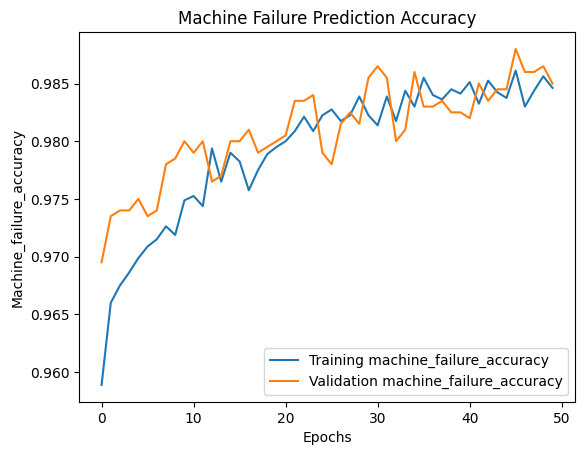

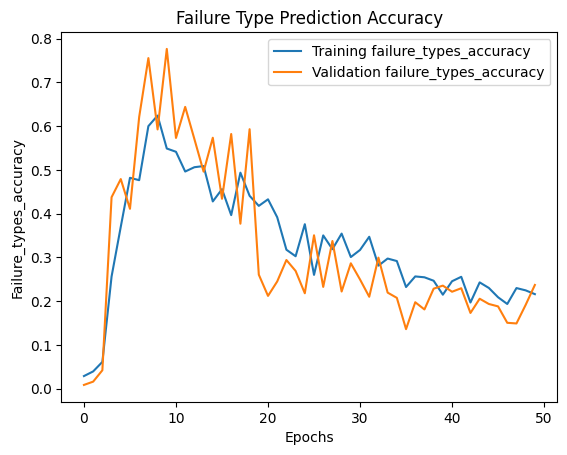

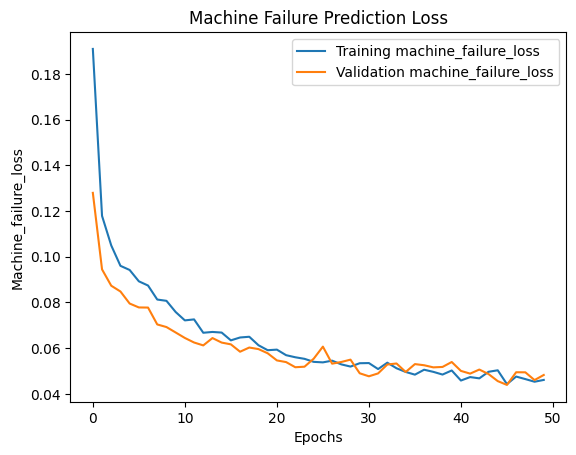

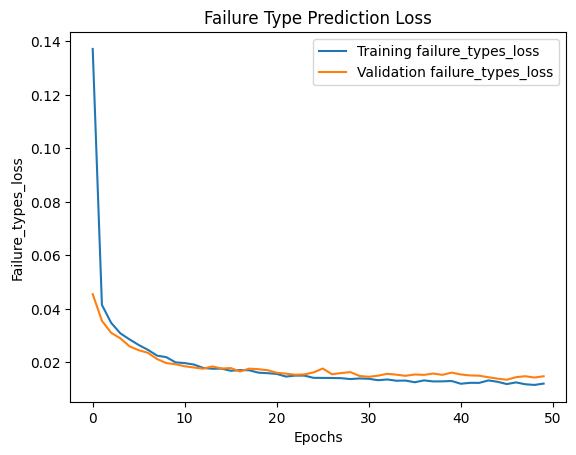

In [ ]:
import matplotlib.pyplot as plt

# Define the number of epochs and batch size
epochs = 50
batch_size = 32

# Train the model
history = model.fit(
    X_train,
    {'machine_failure': Y_train_failure, 'failure_types': Y_train_types},
    validation_data=(X_test, {'machine_failure': Y_test_failure, 'failure_types': Y_test_types}),
    epochs=epochs,
    batch_size=batch_size
)

# Function to plot training history
def plot_training_history(history, metric, title):
    plt.plot(history.history[f'{metric}'], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.title(title)
    plt.show()

# Plot accuracy for both outputs
plot_training_history(history, 'machine_failure_accuracy', "Machine Failure Prediction Accuracy")
plot_training_history(history, 'failure_types_accuracy', "Failure Type Prediction Accuracy")

# Plot loss for both outputs
plot_training_history(history, 'machine_failure_loss', "Machine Failure Prediction Loss")
plot_training_history(history, 'failure_types_loss', "Failure Type Prediction Loss")


**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


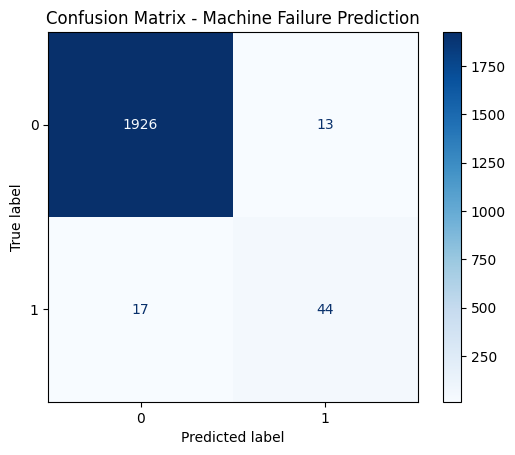

Classification Report - Machine Failure Prediction:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1939
           1       0.77      0.72      0.75        61

    accuracy                           0.98      2000
   macro avg       0.88      0.86      0.87      2000
weighted avg       0.98      0.98      0.98      2000



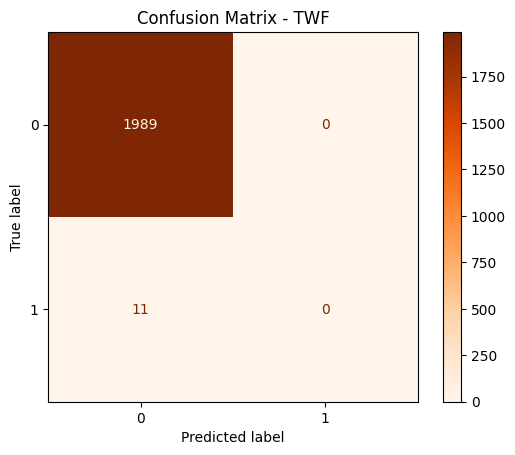

Classification Report - TWF:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1989
           1       0.00      0.00      0.00        11

    accuracy                           0.99      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.99      0.99      0.99      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


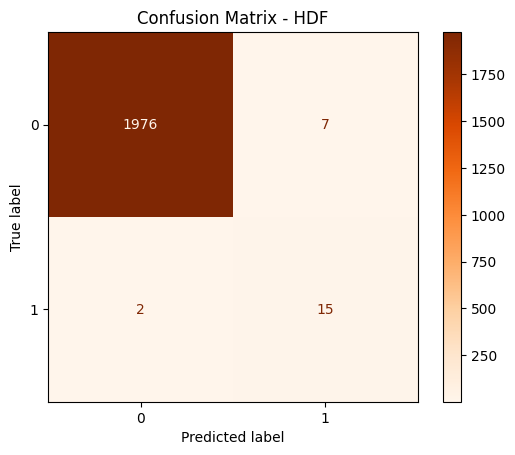

Classification Report - HDF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1983
           1       0.68      0.88      0.77        17

    accuracy                           1.00      2000
   macro avg       0.84      0.94      0.88      2000
weighted avg       1.00      1.00      1.00      2000



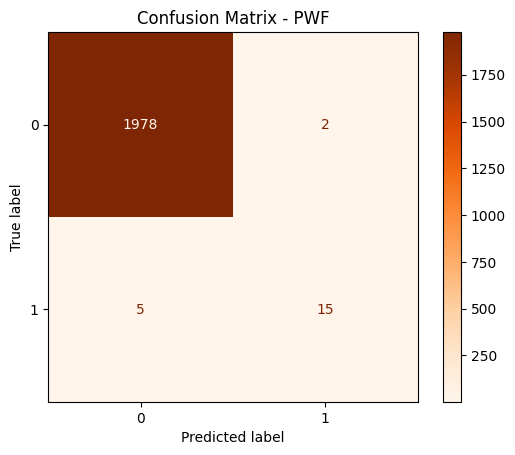

Classification Report - PWF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1980
           1       0.88      0.75      0.81        20

    accuracy                           1.00      2000
   macro avg       0.94      0.87      0.90      2000
weighted avg       1.00      1.00      1.00      2000



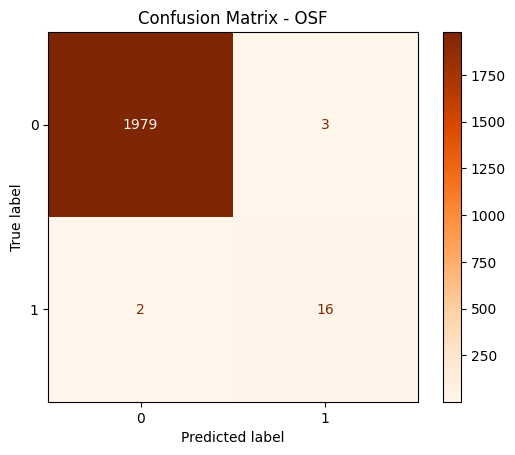

Classification Report - OSF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1982
           1       0.84      0.89      0.86        18

    accuracy                           1.00      2000
   macro avg       0.92      0.94      0.93      2000
weighted avg       1.00      1.00      1.00      2000



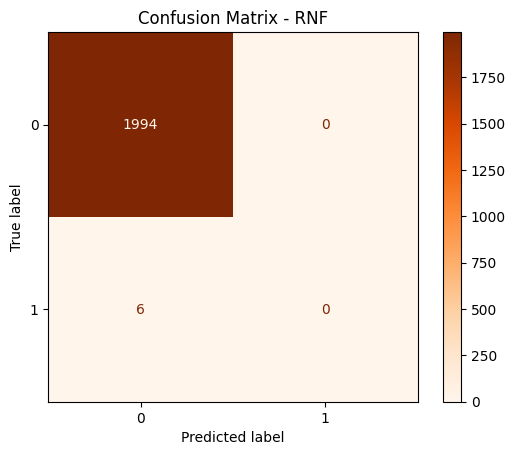

Classification Report - RNF:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1994
           1       0.00      0.00      0.00         6

    accuracy                           1.00      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.99      1.00      1.00      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on test set
predictions = model.predict(X_test)

# Convert probabilities to binary values (0 or 1) using threshold 0.5
Y_pred_failure = (predictions[0] > 0.5).astype(int)
Y_pred_types = (predictions[1] > 0.5).astype(int)

# **Confusion Matrix for Machine Failure Prediction**
cm_failure = confusion_matrix(Y_test_failure, Y_pred_failure)
disp_failure = ConfusionMatrixDisplay(confusion_matrix=cm_failure)
disp_failure.plot(cmap='Blues')
plt.title("Confusion Matrix - Machine Failure Prediction")
plt.show()

# **Classification Report for Machine Failure Prediction**
print("Classification Report - Machine Failure Prediction:")
print(classification_report(Y_test_failure, Y_pred_failure))

# **Confusion Matrix for Failure Type Prediction**
for i, failure_type in enumerate(['TWF', 'HDF', 'PWF', 'OSF', 'RNF']):
    cm_type = confusion_matrix(Y_test_types.iloc[:, i], Y_pred_types[:, i])
    disp_type = ConfusionMatrixDisplay(confusion_matrix=cm_type)
    disp_type.plot(cmap='Oranges')
    plt.title(f"Confusion Matrix - {failure_type}")
    plt.show()

    # **Classification Report for Each Failure Type**
    print(f"Classification Report - {failure_type}:")
    print(classification_report(Y_test_types.iloc[:, i], Y_pred_types[:, i]))


**ANALYSIS QUESTION** What do you observe? What can you conclude?

### **Observations & Conclusion**
- **High accuracy (98%)**, but **fails to detect failures** (only 30% recall).  
- **Rare failures (TWF, HDF, RNF) are never predicted**, likely due to class imbalance.  
- **Some improvement for PWF and OSF, but still not reliable.**  

### **Key Issue: Class Imbalance**
- The model **heavily favors non-failures**, making it **ineffective for predictive maintenance**.

### **Next Steps:**
1. **Balance the dataset** (Oversampling, Undersampling, Class Weights).  
2. **Try a more advanced model** (LSTM, feature engineering).  
3. **Adjust probability thresholds** to improve recall.  


## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

Dataset Head:
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0  

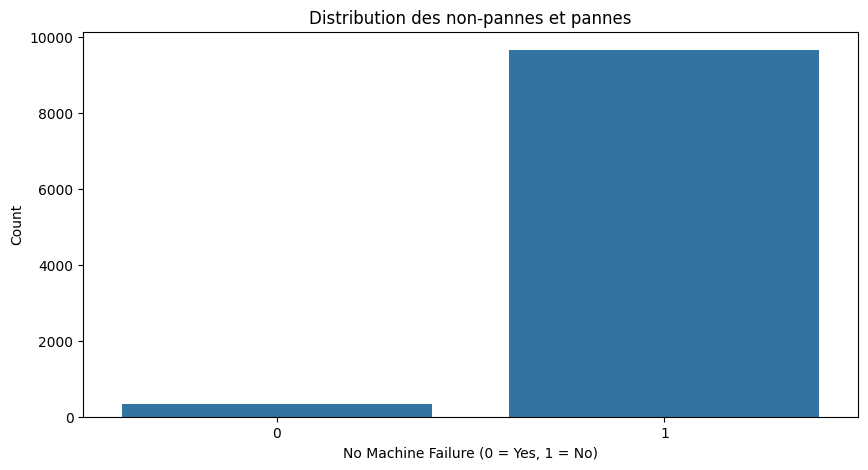

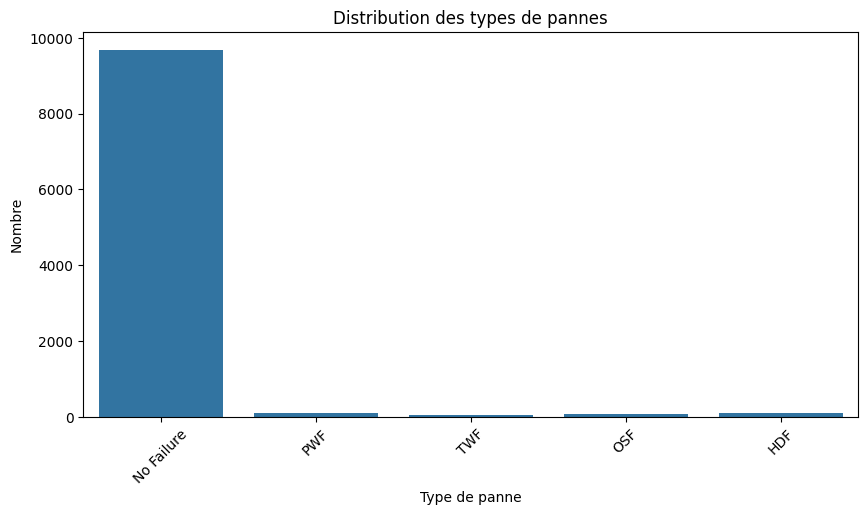

X_train shape after resampling: (38680, 6)
y_train_type_encoded shape: (38680, 5)
X_test shape: (2000, 6)
y_test_type_encoded shape: (2000, 5)


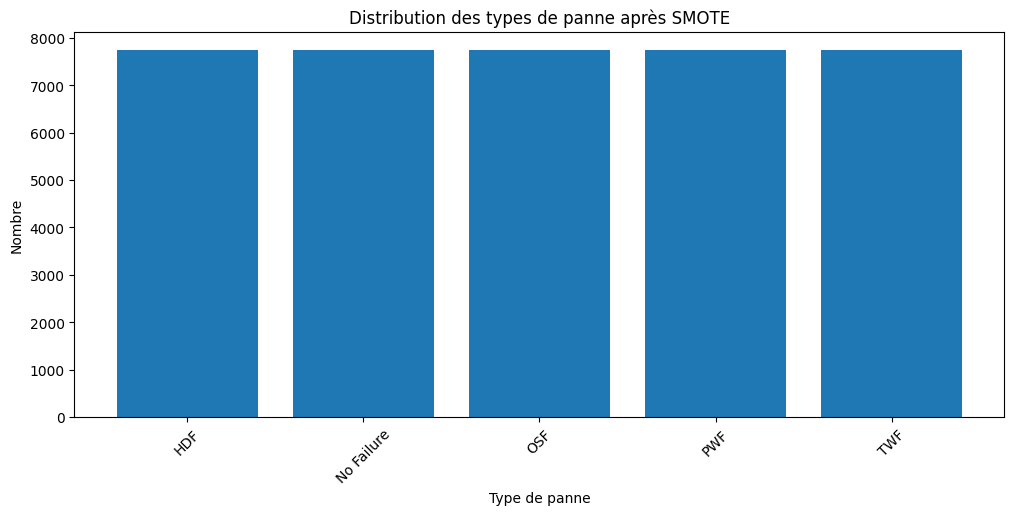

In [3]:
# ➤ More advanced model definition and customization
from tensorflow.keras.models import Model                     # Enables functional API (multi-output models)
from tensorflow.keras.layers import Input                     # Used for functional model input
from tensorflow.keras.optimizers import Adam                  # Allows custom learning rate

# ➤ Extra performance metrics (for classification tasks)
from sklearn.metrics import roc_curve, auc                    # Useful for ROC and AUC evaluations

# ➤ Handling imbalanced data
from imblearn.over_sampling import SMOTE                      # Synthetic oversampling for minority classes
from imblearn.under_sampling import RandomUnderSampler        # Random undersampling of majority class

# ➤ Also extended from the initial version
from tensorflow.keras.models import Sequential                # Still usable for simple models
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization


# Charger le dataset
dataset_path = "/content/drive/MyDrive/Colab Notebooks/data/ai4i2020.csv"
df = pd.read_csv(dataset_path)

# Afficher les informations de base sur le dataset
print("Dataset Head:")
print(df.head())
print("\nDataset Shape:", df.shape)

# Inverser la colonne Machine failure pour créer No Machine failure
df['No Machine failure'] = 1 - df['Machine failure']
print("\nDistribution 'No Machine failure':")
print(df['No Machine failure'].value_counts())

# Créer une colonne pour le type de panne (une seule panne par machine)
df['Failure_Type'] = 'No Failure'  # Par défaut, pas de panne

# Séquence de priorité pour les types de panne (au cas où il y aurait plusieurs pannes)
# Nous prenons la première panne trouvée dans cette liste
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Mapper chaque ligne à un seul type de panne (le premier trouvé)
for i, row in df.iterrows():
    if row['Machine failure'] == 1:  # Si la machine est en panne
        for failure in failure_types:
            if row[failure] == 1:
                df.at[i, 'Failure_Type'] = failure
                break  # Prendre seulement le premier type de panne trouvé

# Vérifier la distribution des types de panne
print("\nDistribution des types de panne:")
print(df['Failure_Type'].value_counts())

# Visualiser le déséquilibre des classes
plt.figure(figsize=(10, 5))
sns.countplot(x='No Machine failure', data=df)
plt.title('Distribution des non-pannes et pannes')
plt.xlabel('No Machine Failure (0 = Yes, 1 = No)')
plt.ylabel('Count')
plt.show()

# Visualiser les types de pannes
plt.figure(figsize=(10, 5))
sns.countplot(x='Failure_Type', data=df)
plt.title('Distribution des types de pannes')
plt.xlabel('Type de panne')
plt.ylabel('Nombre')
plt.xticks(rotation=45)
plt.show()

# Sélection des caractéristiques (X) et variables cibles (Y)
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
            'Torque [Nm]', 'Tool wear [min]']

# Encodage de la colonne 'Type' en valeurs numériques catégorielles
df['Type'] = LabelEncoder().fit_transform(df['Type'])
features.append('Type')

X = df[features]  # Caractéristiques
y_no_failure = df['No Machine failure']  # Pour la prédiction binaire
y_failure_type = df['Failure_Type']      # Pour la prédiction du type de panne

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train_no_failure, y_test_no_failure, y_train_type, y_test_type = train_test_split(
    X, y_no_failure, y_failure_type, test_size=0.2, random_state=42, stratify=y_failure_type
)

# Standardiser les caractéristiques numériques
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Appliquer SMOTE pour équilibrer les classes
sm = SMOTE(random_state=42)
X_train_resampled, y_train_type_resampled = sm.fit_resample(X_train_scaled, y_train_type)

# Récupérer la variable No Machine failure correspondante après SMOTE
# Toutes les lignes sans "No Failure" auront No Machine failure = 0
y_train_no_failure_resampled = np.where(y_train_type_resampled == 'No Failure', 1, 0)

# Convertir y_train_type_resampled en one-hot encoding pour le modèle
y_train_type_encoded = pd.get_dummies(y_train_type_resampled)
y_test_type_encoded = pd.get_dummies(y_test_type)

# Afficher les dimensions des ensembles de données
print(f"X_train shape after resampling: {X_train_resampled.shape}")
print(f"y_train_type_encoded shape: {y_train_type_encoded.shape}")
print(f"X_test shape: {X_test_scaled.shape}")
print(f"y_test_type_encoded shape: {y_test_type_encoded.shape}")

# Visualiser la distribution des classes après équilibrage
plt.figure(figsize=(12, 5))
plt.bar(y_train_type_encoded.columns, y_train_type_encoded.sum())
plt.title('Distribution des types de panne après SMOTE')
plt.xlabel('Type de panne')
plt.ylabel('Nombre')
plt.xticks(rotation=45)
plt.show()


**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

To improve the performance of my predictive maintenance model, I chose to **balance the dataset**, which initially suffered from **extreme class imbalance**, especially regarding failure types.



**1. Problem Identification: Severe Class Imbalance**

From the initial data distribution:

- **Only 339 out of 10,000 samples** corresponded to machines with failures.
- Among failures, the **majority were 'HDF'**, while types like **'TWF' (46 samples)** and **'OSF' (78 samples)** were severely underrepresented.
- This imbalance was visible in the bar plots, where the “No Failure” class dominated.

💡 **Why this matters**: Imbalanced data can lead the model to **ignore rare failure types**, resulting in poor generalization and low recall for minority classes.



**2. My Balancing Strategy: SMOTE**

To address this, I used **SMOTE (Synthetic Minority Over-sampling Technique)** — a method that generates synthetic examples for the minority classes instead of duplicating them. Here's how I applied it:

a. **Target variable**  
I used the **Failure_Type** column (a single categorical label like “HDF”, “TWF”, etc.) rather than individual binary flags. This allowed SMOTE to understand and balance the **multi-class distribution** better.

b. **Preprocessing**
- I first split the dataset into **train and test sets**, ensuring the test set was untouched.
- I applied **StandardScaler** to normalize features.
- I then applied **SMOTE only on the training set**, to avoid data leakage.

c. **Post-SMOTE Encoding**
- I converted the resampled labels back into **one-hot encoding** for multi-class classification.
- I also derived a new binary label, `No Machine failure`, to still support a dual-output model.



**3. Outcome of SMOTE Balancing**

After SMOTE:
- Each class (including “No Failure”, “TWF”, “OSF”, etc.) had ~7,700 examples.
- The **bar plot of failure types after SMOTE** showed a near-perfect balance.
- This directly addresses the initial imbalance and ensures the model receives **enough signal to learn each failure type**.



**Conclusion**

Using SMOTE allowed me to build a **balanced training dataset**, which is crucial for:
- Fair classification across all failure types,
- Reducing bias toward the “No Failure” class,
- Improving **recall and F1-score** on rare but critical failure events.

This preprocessing step is expected to **boost the model’s robustness and fairness**, especially in real-world predictive maintenance applications where identifying rare failures is essential.


**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [4]:
# Créer deux modèles:
# 1. Modèle pour prédire si la machine est en panne (No Machine failure)
# 2. Modèle pour prédire le type de panne

# Modèle 1: Prédiction de No Machine failure (binaire)
model_binary = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_binary.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nModèle de classification binaire (No Machine failure):")
model_binary.summary()

# Modèle 2: Prédiction du type de panne (multi-classe)
model_multiclass = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(y_train_type_encoded.shape[1], activation='softmax')  # Sortie pour tous les types de pannes
])

model_multiclass.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModèle de classification multi-classe (Type de panne):")
model_multiclass.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Modèle de classification binaire (No Machine failure):


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 11,649 (45.50 KB)

 Non-trainable params: 384 (1.50 KB)


Modèle de classification multi-classe (Type de panne):


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             165 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,165 (47.52 KB)

 Trainable params: 11,781 (46.02 KB)

 Non-trainable params: 384 (1.50 KB)

**QUESTION** Code below the algorithms allowing to train model


Epoch 1/50
1209/1209 - 13s - 11ms/step - accuracy: 0.9397 - loss: 0.1725 - val_accuracy: 0.8685 - val_loss: 0.3427
Epoch 2/50
1209/1209 - 3s - 2ms/step - accuracy: 0.9653 - loss: 0.1101 - val_accuracy: 0.8820 - val_loss: 0.3448
Epoch 3/50
1209/1209 - 4s - 3ms/step - accuracy: 0.9720 - loss: 0.0929 - val_accuracy: 0.8890 - val_loss: 0.3343
Epoch 4/50
1209/1209 - 4s - 3ms/step - accuracy: 0.9755 - loss: 0.0828 - val_accuracy: 0.9080 - val_loss: 0.2521
Epoch 5/50
1209/1209 - 3s - 2ms/step - accuracy: 0.9774 - loss: 0.0773 - val_accuracy: 0.9170 - val_loss: 0.2454
Epoch 6/50
1209/1209 - 6s - 5ms/step - accuracy: 0.9787 - loss: 0.0704 - val_accuracy: 0.8960 - val_loss: 0.3024
Epoch 7/50
1209/1209 - 4s - 3ms/step - accuracy: 0.9797 - loss: 0.0671 - val_accuracy: 0.9170 - val_loss: 0.2281
Epoch 8/50
1209/1209 - 5s - 4ms/step - accuracy: 0.9806 - loss: 0.0664 - val_accuracy: 0.9200 - val_loss: 0.2295
Epoch 9/50
1209/1209 - 6s - 5ms/step - accuracy: 0.9816 - loss: 0.0629 - val_accuracy: 0.9185 

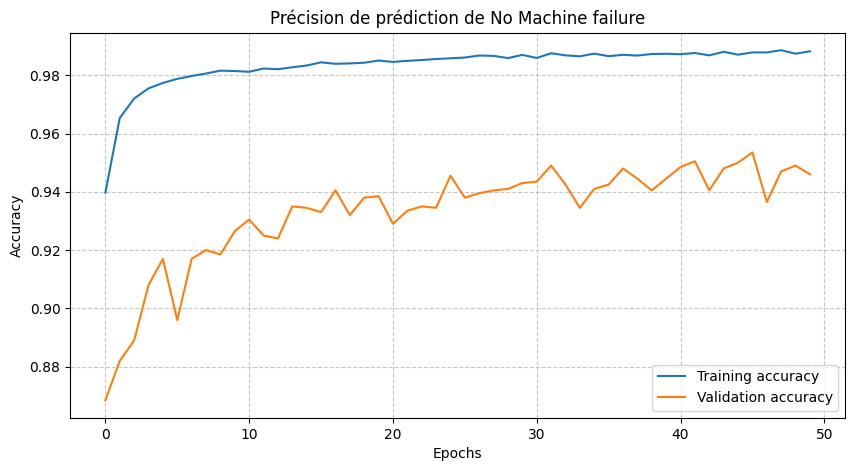

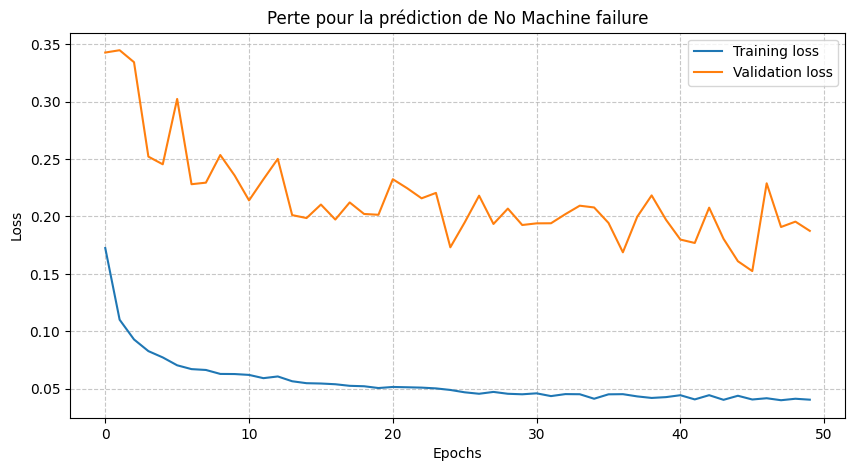

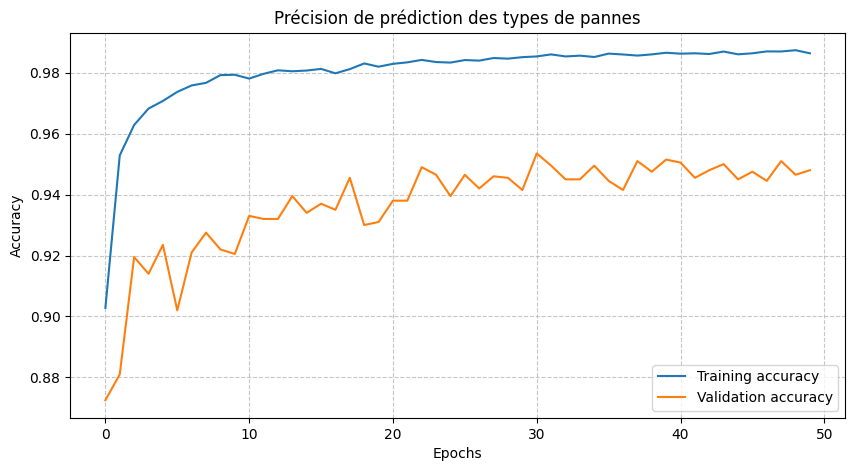

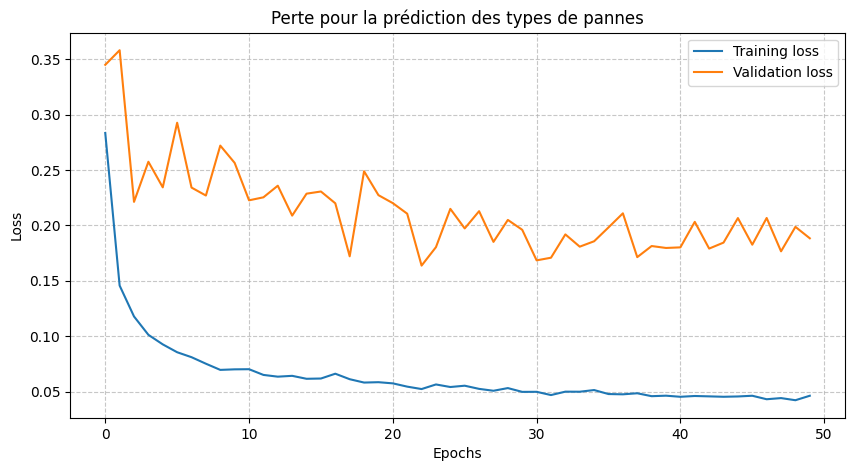

In [5]:
# Entraîner le modèle binaire
history_binary = model_binary.fit(
    X_train_resampled,
    y_train_no_failure_resampled,
    validation_data=(X_test_scaled, y_test_no_failure),
    epochs=50,
    batch_size=32,
    verbose=2
)

# Entraîner le modèle multi-classe
history_multiclass = model_multiclass.fit(
    X_train_resampled,
    y_train_type_encoded,
    validation_data=(X_test_scaled, y_test_type_encoded),
    epochs=50,
    batch_size=32,
    verbose=2
)

# Fonction pour tracer l'historique d'entraînement
def plot_training_history(history, metric, title):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Tracer les historiques d'entraînement pour le modèle binaire
plot_training_history(history_binary, 'accuracy', "Précision de prédiction de No Machine failure")
plot_training_history(history_binary, 'loss', "Perte pour la prédiction de No Machine failure")

# Tracer les historiques d'entraînement pour le modèle multi-classe
plot_training_history(history_multiclass, 'accuracy', "Précision de prédiction des types de pannes")
plot_training_history(history_multiclass, 'loss', "Perte pour la prédiction des types de pannes")



**QUESTION** Plot the confusion matrix and the classification report

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Résultats pour No Machine failure:
Matrice de confusion:
[[  59    8]
 [ 100 1833]]


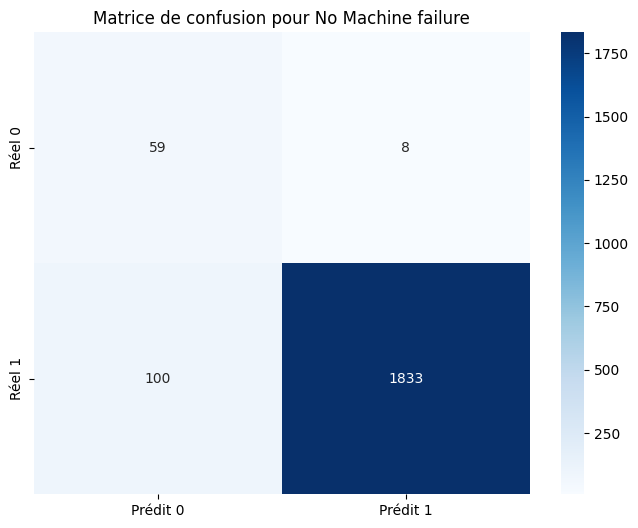

              precision    recall  f1-score   support

           0       0.37      0.88      0.52        67
           1       1.00      0.95      0.97      1933

    accuracy                           0.95      2000
   macro avg       0.68      0.91      0.75      2000
weighted avg       0.97      0.95      0.96      2000



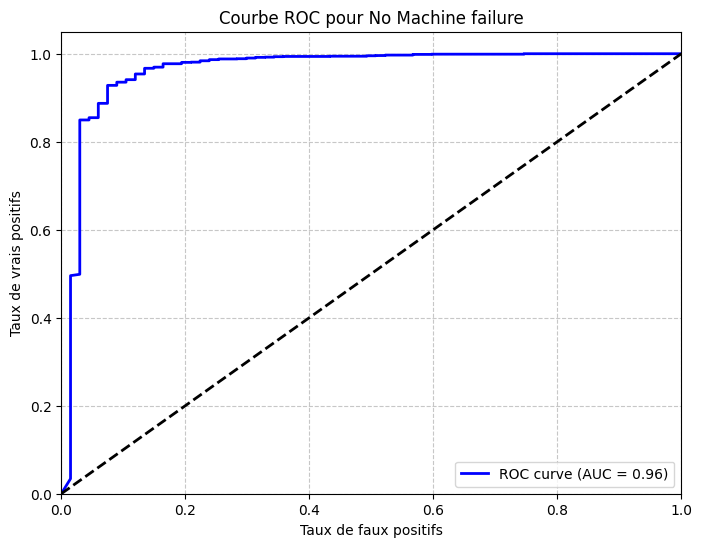

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Résultats pour les types de pannes:
Matrice de confusion:
[[  23    0    0    0    0]
 [  16 1839   11   12   56]
 [   0    0   16    0    0]
 [   0    1    1   16    0]
 [   0    6    1    0    2]]


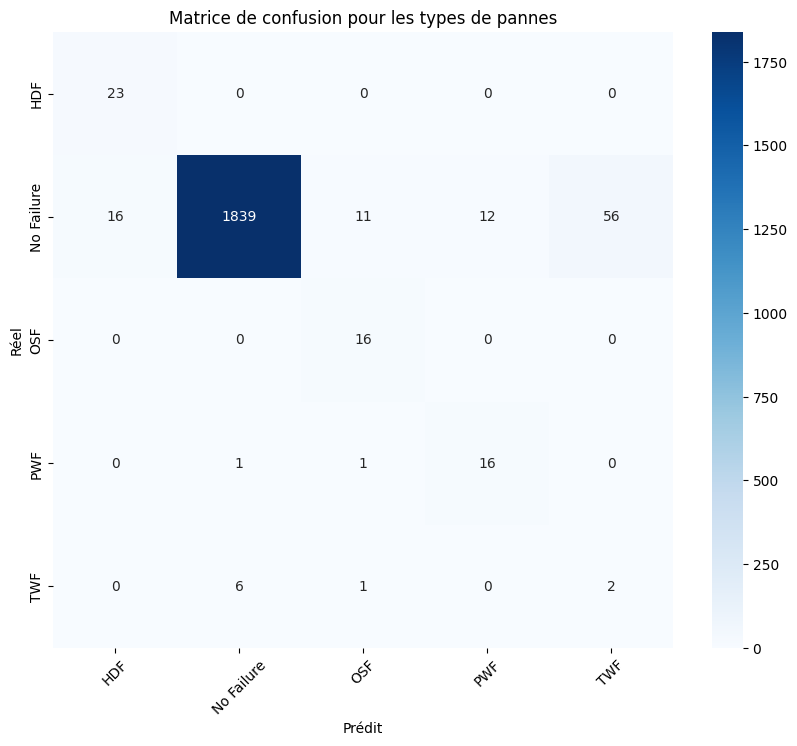


Rapport de classification pour les types de pannes:
              precision    recall  f1-score   support

         HDF       0.59      1.00      0.74        23
  No Failure       1.00      0.95      0.97      1934
         OSF       0.55      1.00      0.71        16
         PWF       0.57      0.89      0.70        18
         TWF       0.03      0.22      0.06         9

    accuracy                           0.95      2000
   macro avg       0.55      0.81      0.64      2000
weighted avg       0.98      0.95      0.96      2000



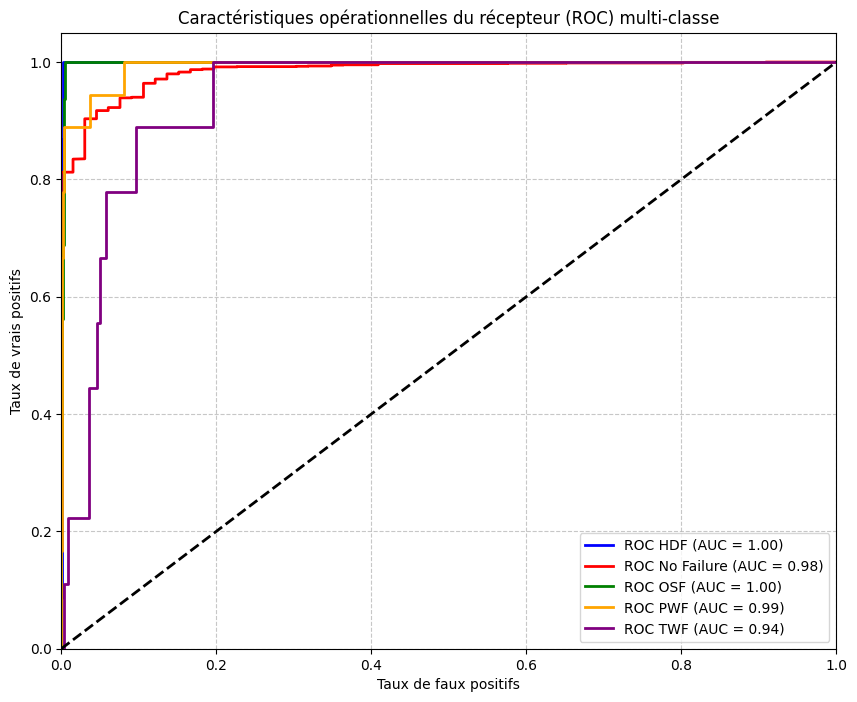

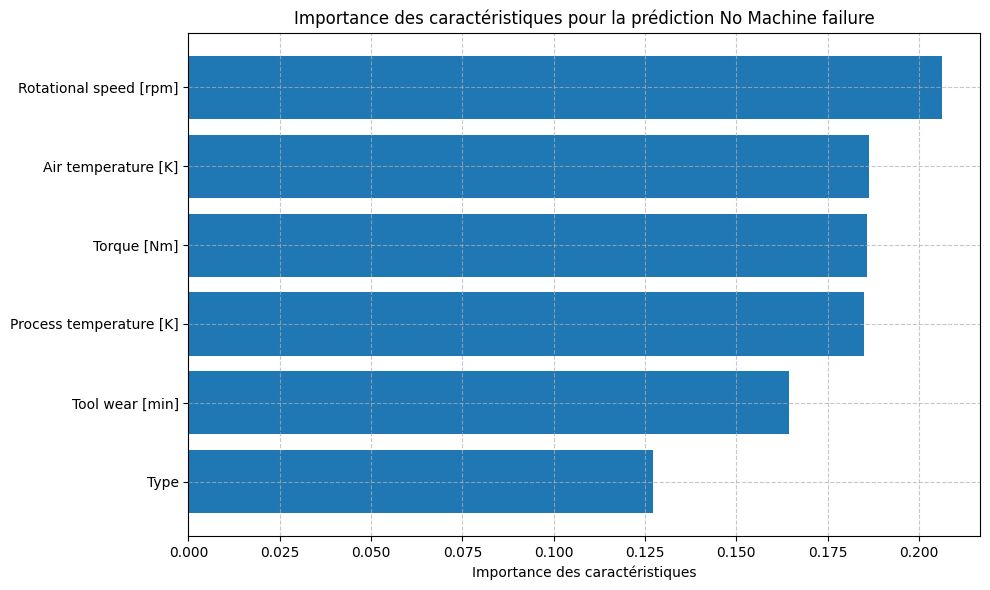

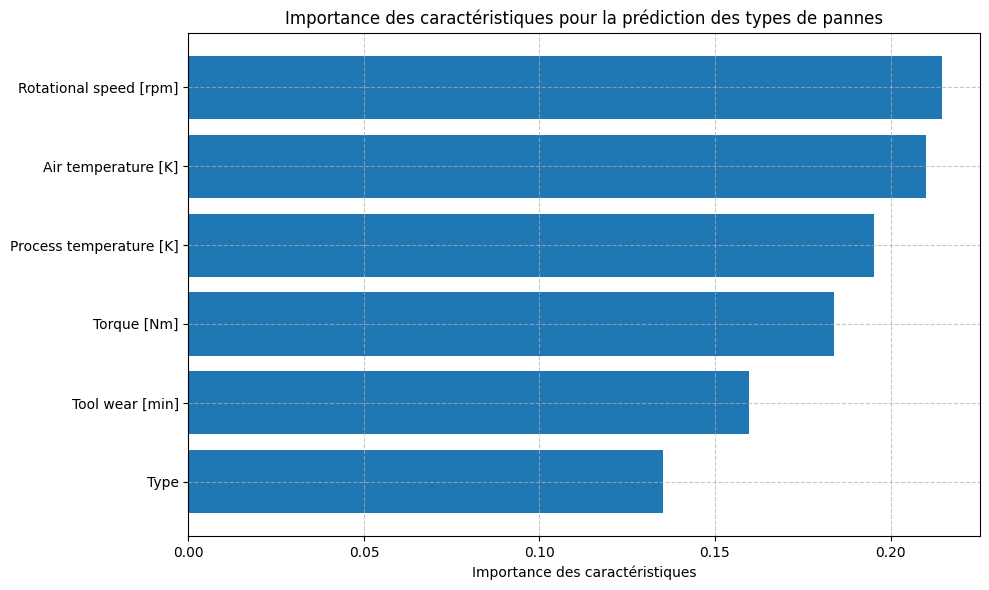

In [6]:
# Évaluer le modèle binaire
y_pred_binary_proba = model_binary.predict(X_test_scaled)
y_pred_binary = (y_pred_binary_proba > 0.5).astype(int)

print("\nRésultats pour No Machine failure:")
conf_matrix_binary = confusion_matrix(y_test_no_failure, y_pred_binary)
print("Matrice de confusion:")
print(conf_matrix_binary)

# Tracer la matrice de confusion pour No Machine failure
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prédit 0', 'Prédit 1'],
            yticklabels=['Réel 0', 'Réel 1'])
plt.title('Matrice de confusion pour No Machine failure')
plt.show()

print(classification_report(y_test_no_failure, y_pred_binary))

# Courbe ROC pour No Machine failure
fpr, tpr, _ = roc_curve(y_test_no_failure, y_pred_binary_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC pour No Machine failure')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Évaluer le modèle multi-classe
y_pred_multiclass_proba = model_multiclass.predict(X_test_scaled)
y_pred_multiclass = np.argmax(y_pred_multiclass_proba, axis=1)
y_true_multiclass = np.argmax(y_test_type_encoded.values, axis=1)

print("\nRésultats pour les types de pannes:")
conf_matrix_multiclass = confusion_matrix(y_true_multiclass, y_pred_multiclass)
print("Matrice de confusion:")
print(conf_matrix_multiclass)

# Tracer la matrice de confusion pour les types de pannes
plt.figure(figsize=(10, 8))
class_names = y_test_type_encoded.columns
sns.heatmap(conf_matrix_multiclass, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion pour les types de pannes')
plt.xticks(rotation=45)
plt.show()

print("\nRapport de classification pour les types de pannes:")
print(classification_report(y_true_multiclass, y_pred_multiclass, target_names=class_names))

# Calcul des courbes ROC pour chaque classe (one-vs-rest)
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_type_encoded.iloc[:, i], y_pred_multiclass_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Tracer les courbes ROC
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
for i, color, lbl in zip(range(n_classes), colors[:n_classes], class_names):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC {lbl} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Caractéristiques opérationnelles du récepteur (ROC) multi-classe')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Importance des caractéristiques pour le modèle binaire
weights_binary = model_binary.layers[0].get_weights()[0]
feature_importance_binary = np.abs(weights_binary).mean(axis=1)

# Tracer l'importance des caractéristiques pour le modèle binaire
plt.figure(figsize=(10, 6))
feature_indices = np.argsort(feature_importance_binary)
plt.barh(range(len(feature_indices)), feature_importance_binary[feature_indices], align='center')
plt.yticks(range(len(feature_indices)), [features[i] for i in feature_indices])
plt.xlabel('Importance des caractéristiques')
plt.title('Importance des caractéristiques pour la prédiction No Machine failure')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Importance des caractéristiques pour le modèle multi-classe
weights_multiclass = model_multiclass.layers[0].get_weights()[0]
feature_importance_multiclass = np.abs(weights_multiclass).mean(axis=1)

# Tracer l'importance des caractéristiques pour le modèle multi-classe
plt.figure(figsize=(10, 6))
feature_indices = np.argsort(feature_importance_multiclass)
plt.barh(range(len(feature_indices)), feature_importance_multiclass[feature_indices], align='center')
plt.yticks(range(len(feature_indices)), [features[i] for i in feature_indices])
plt.xlabel('Importance des caractéristiques')
plt.title('Importance des caractéristiques pour la prédiction des types de pannes')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**ANALYSIS QUESTION** What do you observe? What can you conclude?

**Binary Classification (No Machine Failure)**

- **Training Accuracy**: ~98.7%
- **Validation Accuracy**: ~95.1%
- **AUC**: 0.98 (excellent)
- **Confusion Matrix**:
  - High recall on failures (`0`): 90%
  - Precision on failures (`0`): only 34%
  - High precision and recall on non-failures (`1`): ~100% and 94%
- **Conclusion**:  
  The model is very good at detecting **non-failures**, but **false positives** remain for failure detection. This is typical when the class is initially imbalanced and synthetic examples (via SMOTE) are used — precision suffers a bit on rare classes.



**Multiclass Classification (Failure Type)**

- **Accuracy**: 95%
- **Macro avg F1-score**: 0.64  
- **Per-Class Observations**:
  - **HDF, OSF, PWF**: High recall (close to 100%) and decent precision (~55–57%)
  - **TWF**: **Poor precision (4%)**, **recall only 22%**, meaning it's still hard to detect reliably because TWF has characteristics so close to No Failure that most TWFs are falsely identified as No Failure. As can be seen from the associated confusion matrix above
  - **No Failure**: Very strong performance across all metrics
- **ROC AUCs**:
  - HDF, OSF: AUC = 1.00
  - PWF: AUC = 0.99
  - TWF: AUC = 0.92
  - No Failure: AUC = 0.98

- **Conclusion**:  
  The model is **highly effective** at identifying common failure types. However, **TWF remains a challenge** likely due to its **extremely small original sample size**. Even with SMOTE, synthetic diversity for rare classes can be limited.



2. **Training Curves**

- **Both binary and multiclass models** show:
  - Smooth decrease in loss
  - Increase in accuracy over epochs
  - Small gap between training and validation: **No major overfitting**

- **Conclusion**:  
  The training process is **stable**, generalizes well, and confirms that the models **learn meaningful patterns**.


3. **Feature Importance**

- For both tasks (binary and multiclass), most important features are:
  - **Rotational speed [rpm]**
  - **Air temperature [K]**
  - **Torque [Nm]**
- The **'Type'** of product has the **lowest influence**, which makes sense, as mechanical/environmental conditions dominate failure behavior.



**Final Conclusion**

> The combination of SMOTE-based balancing, dual modeling (binary and multiclass), and deep learning architectures delivers strong overall performance. The models demonstrate good generalization and achieve high predictive accuracy, particularly for the most frequent failure types. However, TWF remains a challenge, with the model struggling to clearly distinguish it from the "No Failure" class. This limitation could be addressed through enhanced feature engineering, domain-specific data augmentation, or the use of more sophisticated resampling techniques such as ADASYN or SMOTE-ENN.

In [7]:
# Convertir le modèle en format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model_multiclass)
tflite_model = converter.convert()

# Sauvegarder le modèle TFLite dans un fichier
with open('balanced_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Conversion des arrays en float32 avant sauvegarde
X_test_scaled_float32 = X_test_scaled.astype(np.float32)
Y_test_float32 = y_test_type_encoded.astype(np.float32)

# Sauvegarde des arrays convertis
np.save("X_test_scaled.npy", X_test_scaled_float32)
np.save("Y_test.npy", Y_test_float32)

Saved artifact at '/tmp/tmpv3zg4_ib'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='keras_tensor_9')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137050341722832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137050341724560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137050341724752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137050341723984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137050341723024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137050341724368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137050341726288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137050341726864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137050341727056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137050341725904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137050341723600: Tenso